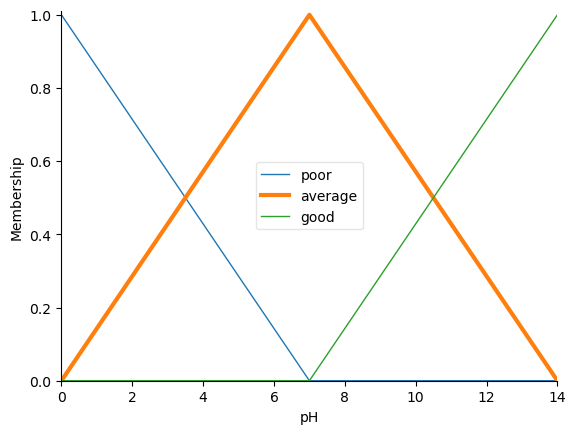

In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
pH = ctrl.Antecedent(np.arange(0, 15, 1), 'pH')

# service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
suitability = ctrl.Consequent(np.arange(0, 1, .001), 'suitability')

# # Auto-membership function population is possible with .automf(3, 5, or 7)
pH.automf(3)
# service.automf(3)

# # Custom membership functions can be built interactively with a familiar,
# # Pythonic API
suitability['low'] = fuzz.trimf(suitability.universe, [0, 0, .5])
suitability['medium'] = fuzz.trimf(suitability.universe, [0, .5, 1])
suitability['high'] = fuzz.trimf(suitability.universe, [.5, 1, 1])

pH['average'].view()

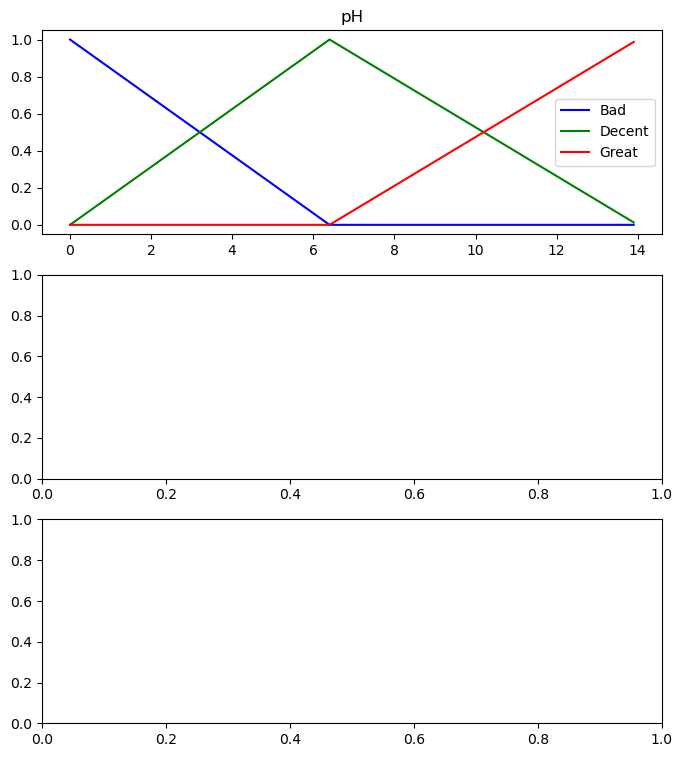

In [6]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_pH = np.arange(0, 14, .1)
x_suitability  = np.arange(0, 1, .01)

# Generate fuzzy membership functions
ph_too_low = fuzz.trimf(x_pH, [0, 0, 6.4])
qual_good = fuzz.trimf(x_pH, [0, 6.4, 14])
qual_too_high = fuzz.trimf(x_pH, [6.4, 14, 14])


ph_good = fuzz.gaussmf

tip_lo = fuzz.trimf(x_suitability, [0, 0, .5])
tip_md = fuzz.trimf(x_suitability, [0, .5, 1])
tip_hi = fuzz.trimf(x_suitability, [.5, 1, 1])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_pH, ph_too_low, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_pH, qual_good, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_pH, qual_too_high, 'r', linewidth=1.5, label='Great')
ax0.set_title('pH')
ax0.legend()


In [8]:
x_serv = np.arange(0, 11, 1)

serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])

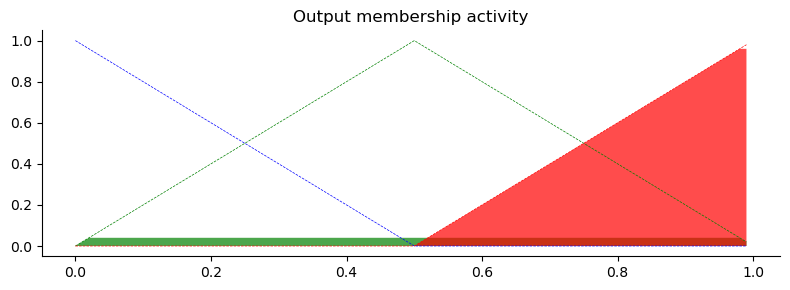

In [9]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_pH, ph_too_low, 6.5)
qual_level_md = fuzz.interp_membership(x_pH, qual_good, 6.5)
qual_level_hi = fuzz.interp_membership(x_pH, qual_too_high, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_suitability)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_suitability, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_suitability, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_suitability, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_suitability, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_suitability, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_suitability, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


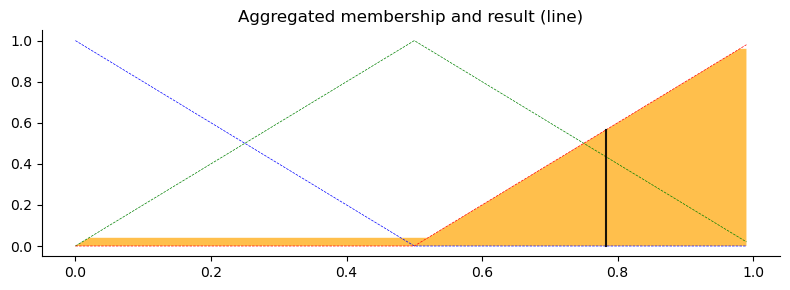

In [10]:
# Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_suitability, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_suitability, aggregated, tip)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_suitability, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_suitability, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_suitability, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_suitability, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()